## Implement Deep Q-Networks on Playing Games
Reference Codes: https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow

#### Data: 
Here the data is a game environment offered by OpenAI Gym. Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Tetris and chess. 

### Reinforcement Learning 
Reinforcement Learning is learning through interaction with an environment by taking a sequence of actions and by experiencing failures and successes while trying to maximize the rewards. Reinforcement learning systems have 4 main elements:
-Policy (A mapping from the perceived states of the environment to the actions to be taken when in those states)
-Reward signal (Given directly from the enviroment at each step)
-Value function (The value of a state is the total amount of reward an agent can expect to accumulate over the future, starting in that state)
-Model

#### Q-Learning: 
Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward. 

#### DQN:
If the combinations of states and actions are too large, the memory and the computation requirement for Q will be too high. To address that, switch to a deep network Q (DQN) to approximate Q(s, a). The learning algorithm is called Deep Q-learning. The new approach generalizes the approximation of the Q-value function rather than remembering the solutions. There are two neural networks here, the evaluate network and the target network. They have exactly the same structure but different parameters. The evaluate network is to retrive Q values while the target neural network is to store all updates in the training. After a certain steps of training, here replace_target_iter=300, the two networks would be synchronized. The purpose is to fix the Q-value targets temporarily so we don’t have a moving target to chase. With both experience replay and the target network, we have a more stable input and output to train the network and behaves more like supervised training.




In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

##### Build the DQN model
Class DeepQNetWork is to build the deep q network for training the game. 

##### __init__: 
To initialize all  the parameters to be used in this model
:param n_actions: Number of available actions to be taken in the game
:param n_features: Number of features
:param learning_rate: (.1)Gamma, how fast the model learns from the difference between actual and predict
:param reward_decay: (.9)Decay rates on future reward
:param e_greedy: (.9)(Greedy strategy). Maixmum epsilon:0.9, 90% of the time the model choose to maximize the value according to the table.
:param replace_target_iter: Number of steps to update target_net
:param memory_size: Maximum number of states-action pair that the model can remember
:param batch_size: Number of states-action pair to take from memmory each time
:param e_greedy_increment: Increment of epsilon
:param output_graph: If true, output tensorboard file
Memory: Q-Learning table
learn_step_counter: Record current number of learning steps. When learn_step_counter reaches to replace_target_iter, the model will update target_net
          
##### _build_net: 
Build the two neural networks, the evaluate network and the target network. The evaluate network is to retrive Q values while the target neural network is to store all updates in the training. After a certain steps of training, here replace_target_iter=300, the two networks would be synchronized.

##### store_transition:
Off-Policy. Record all the steps that the model has gone through. On each call, it records one (state, action,  reward, next state) memory. When current memory reaches to the maximum memory size, replace the old memory with new memory. 

##### choose_action: 
This function decides which action to take at each step. 90% of the chance it would select a action that maximizes the value of action from the eval_net. 10% of the chance it would select a random action from all available actions. 

##### learn: 
How the model actually study form QDN (Update the q leanring value table). It would first check if the number of steps reaches to the maximum number of steps to update target_net and update accordingly. Then it randomly choose a batch of memory from available memories. Here, evaluate network and target network would synchronize. 

In [2]:
# Deep Q Network off-policy
class DeepQNetwork(object):
    def __init__(
            self,
            # Number of available actions to be taken in the game
            n_actions, 
            n_features, 
            # Gamma, how fast the model learns from the difference between actual and predict
            learning_rate=0.01,
            # Decay rates on future reward
            reward_decay=0.9,
            #(Greedy strategy). Maixmum epsilon:0.9, 90% of the time the model choose to maximize the value according to the table.
            e_greedy=0.9,
            # Number of steps to synchronize target_net
            replace_target_iter=300,
            # Maximum number of states-action pair that the model can remember
            memory_size=500,
            # Number of states-action pair to take from memmory each time
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions 
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        
        
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        
        # get parameters from target_net
        t_params = tf.get_collection('target_net_params')
        
        # get parameters from eval_net
        e_params = tf.get_collection('eval_net_params')
        
        # update parameters of target_net
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()
        
        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        
        # record the changes of cost
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2
    
    
    # Records all the steps the model has gone through. 
    # On each call, it records one (state, action, reward, next state) memory. 
    # When current memory reaches to the maximum memory size, replace the old memory with new memory.
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action
    
    
    # How the model actually study form QDN. 
    # It would first check if the number of steps reaches to the maximum number of steps to update target_net and update accordingly. 
    # Then it randomly choose a batch of memory from available memories.
    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]
        
        # get q_next
        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


### Run DQN model to train the mountain car
This part is to use the QDN model built above and train the car to go to the peak of the mountain. At each episode, the model observes the initial environment from last episode. At each step of the current episode, the model will choose an action to take given the current state. (In the earlier training stage, the greedy epsilon is small, most of the time the model would choose a random action rather than trying to maximize the value according to the table.) After choosing action at each step, the model would observe a state offered by the environment as a correspond to the action that the model has chosen. Then the model would store this (curr_state, action, reward, next_state) when the model accumulates certain amount of memories(steps), the model would start to learn(update the q learning table by bellman function) and then update the current state to next state. 

In [3]:
env = gym.make('MountainCar-v0')
env = env.unwrapped

RL = DeepQNetwork(n_actions=3, n_features=2, learning_rate=0.001, e_greedy=0.9,
                  replace_target_iter=300, memory_size=3000,
                  e_greedy_increment=0.0002,)

total_steps = 0


for i_episode in range(10):

    observation = env.reset()
    ep_r = 0
    while True:
        # Refresh the environment 
        env.render()
        
        # DQN chooses action according to the observation 
        action = RL.choose_action(observation)
        
        # The environment gives the next state, reward and check if terminate
        observation_, reward, done, info = env.step(action)

        position, velocity = observation_

        # the higher the better
        reward = abs(position - (-0.5))     # r in [0, 1]
        
        # DQN stores memories 
        RL.store_transition(observation, action, reward, observation_)

        if total_steps > 1000:
            RL.learn()

        ep_r += reward
        if done:
            get = '| Get' if observation_[0] >= env.unwrapped.goal_position else '| ----'
            print('Epi: ', i_episode,
                  get,
                  '| Ep_r: ', round(ep_r, 4),
                  '| Epsilon: ', round(RL.epsilon, 2))
            break

        observation = observation_
        total_steps += 1


Instructions for updating:
Colocations handled automatically by placer.

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced

Epi:  0 | Get | Ep_r:  1893.9832 | Epsilon:  0.9

target_params_replaced


target_params_replaced


target_params_replaced

Epi:  1 | Get | Ep_r:  390.3249 | Epsilon:  0.9

target_params_replaced


targe

#### The cost plot
Unlike supervised learning, the cost function plot is not smoothly declined. This is because the input of DQN is changing after learning from each step. (The 'label'is not consistent)

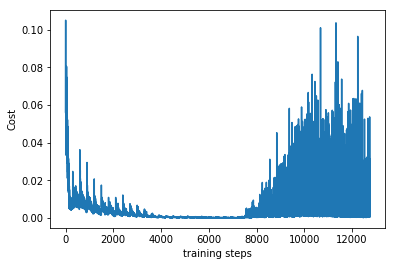

In [5]:
RL.plot_cost()